In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from curvefit.core.model import CurveModel
from curvefit.core.functions import ln_gaussian_cdf, gaussian_cdf
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

In [84]:
# Fetches the data from the COVID19India website
class DataFetcher:
    def __init__(self, url="https://api.covid19india.org/data.json"):
        self.url = url
        self.json_data = None
        self.cases_time_series = None
        
    def fetch(self):
        r = requests.get(url=self.url)
        self.json_data = r.json()
        
        # Get the fields
        fields = list(self.json_data['cases_time_series'][0].keys())
        self.cases_time_series = {}
        
        for field in fields:
            if field == 'date':
                self.cases_time_series[field] = [x[field] for x in self.json_data['cases_time_series']]
            else:
                self.cases_time_series[field] = np.array([float(x[field]) for x in self.json_data['cases_time_series']])

In [85]:
class GaussianCDF:
    """Fit a single Gaussian Atom to cumulative daily deaths"""
    
    def __init__(self):
        self.model = None
    
    def fit(self, daily_deaths):
        daily_deaths = np.array(daily_deaths)
        
        # Prepare the data frame
        df = pd.DataFrame()
        df['death_rate'] = np.cumsum(daily_deaths)
        df['time'] = np.arange(df['death_rate'].shape[0])
        df['ln_death_rate'] = np.log(df['death_rate'] + 1) # Add 1 to pad in case the #deaths are zero
        df['group'] = 'all'
        df['cov_one'] = 1.0 # Constant covariate
        
        # Set up the CurveModel
        self.model = CurveModel(
            df=df,
            col_t='time',
            col_obs='ln_death_rate',
            col_group='group',
            col_covs=[['cov_one'], ['cov_one'], ['cov_one']],
            param_names=['alpha', 'beta', 'p'],
            link_fun=[lambda x: np.exp(x), lambda x: x, lambda x: np.exp(x)],
            var_link_fun=[lambda x: x, lambda x: x, lambda x: x],
            fun=ln_gaussian_cdf
        )

        # Fit the model to estimate parameters
        self.model.fit_params(
            fe_init=[-3, 100, 1],
            options={
                'ftol': 1e-14,
                'maxiter': 500
            },
            re_bounds= [[0, 0]] * 3    # No random effects
        )
    
    def predict(self, t):
        """Get predictions for values in t"""
        
        return self.model.predict(t=t, group_name='all')
    
    def get_params(self):
        return np.squeeze(model.params)

In [86]:
class MultiGaussianCDF:
    """Mixture of Gaussians with staggered peaks"""
    
    def __init__(self, params, k=6, inc=2):
        self.params = params
        self.k = k
        self.inc = inc
        self.weights = None
        
    def compute_x(self, ln_death_rate):
        X = np.zeros((ln_death_rate.shape[0], 2 * self.k + 1))
        self.params[2] -= self.inc * self.k
        
        t = np.arange(ln_death_rate.shape[0])
        
        for j in range(2 * self.k + 1):
            X[:, j] = ln_gaussian_cdf(t, params)
            params[2] += self.inc
            
        return X
        
    def fit(self, ln_death_rate):
        X = self.compute_x(ln_death_rate)
        y = ln_death_rate
        
        reg = LinearRegression(fit_intercept=False)
        reg.fit(X, y)
        self.weights = reg.coef_
        
    def predict(self, t):
        X = self.compute_x(t)
        return X @ self.weights

<h2>Fitting a model for cumulative number of deaths in India</h2>

Description - the model is a generalized fixed effects model. Since there is only one location (for now) the link functions are simple and random effects are neglected. Further, social distancing covariates are ignored as a first approximation. 

$$f(t; \alpha, \beta, p) =
        \frac{p}{2} \left( 1 + \frac{2}{\pi} \int_0^{\alpha ( t - \beta )}
            \exp( - \tau^2 ) d \tau \right)$$
            
Here, $f$ is the cumulative number of deaths and $\alpha, \beta, p$ are parameters with the following link functions

\begin{aligned}
    \alpha & = \exp( a ) \\
    \beta  & =  b \\
    p      & = \exp( \phi  )
\end{aligned}

where $a, b, \phi$ are fixed effects learnt by the model

<h3>Single Gaussian Atom</h3>

In [101]:
fetcher = DataFetcher()
fetcher.fetch()

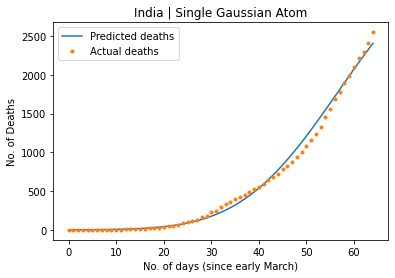

In [102]:
offset = 40 # Ignore the first 40 observations
death_data = fetcher.cases_time_series['dailydeceased'][offset:]
time_values = np.arange(death_data.shape[0])

model_india = GaussianCDF()
model_india.fit(death_data)
pred = model_india.predict(time_values)

plt.plot(time_values, np.exp(pred), label="Predicted deaths")
plt.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
plt.title("India | Single Gaussian Atom")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative no. of Deaths")
plt.legend()
plt.show()

<h3>13 Gaussian Atoms with staggered peaks</h3>

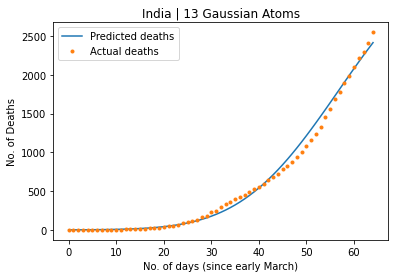

In [104]:
params = model_india.get_params()
multi_gauss = MultiGaussianCDF(params)
ln_death_rate = np.log(np.cumsum(death_data) + 1)
multi_gauss.fit(ln_death_rate)

preds = multi_gauss.predict(np.arange(ln_death_rate.shape[0]))
plt.plot(np.exp(preds), label="Predicted deaths")
plt.plot(np.cumsum(death_data), '.', label="Actual deaths")
plt.title("India | 13 Gaussian Atoms")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative no. of Deaths")
plt.legend()
plt.show()

<h2>Fitting a model for cumulative number of deaths in MH</h2>

In [105]:
class DataFetcherState:
    """Fetch data for all states"""
    
    def __init__(self):
        self.data = None
        self.raw_data = None
    
    def fetch(self):
        # Fetch the raw data
        r = requests.get(url="https://api.covid19india.org/states_daily.json")
        self.raw_data = r.json()
        self.data = {}
        
        # Iterate over the days and record the data
        for entry in self.raw_data['states_daily']:
            status = entry['status'].lower()
            for state in entry:
                if state == "date" or state == "status":
                    continue
                    
                if state not in self.data:
                    # Initialize this state
                    self.data[state] = {
                        'deceased': [],
                        'recovered': [],
                        'confirmed': []
                    }
                
                # Append the data
                self.data[state][status].append(entry[state])

<h2>Single Gaussian Atom</h2>

In [106]:
fetcher = DataFetcherState()
fetcher.fetch()

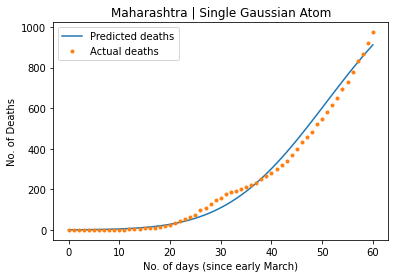

In [107]:
death_data = np.array(fetcher.data['mh']['deceased'], dtype=float)
time_values = np.arange(death_data.shape[0])

model_mh = GaussianCDF()
model_mh.fit(death_data)
pred = model_mh.predict(time_values)

plt.plot(time_values, np.exp(pred), label="Predicted deaths")
plt.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
plt.title("Maharashtra | Single Gaussian Atom")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative no. of Deaths")
plt.legend()
plt.show()

<h2>Multiple Gaussian Atoms</h2>

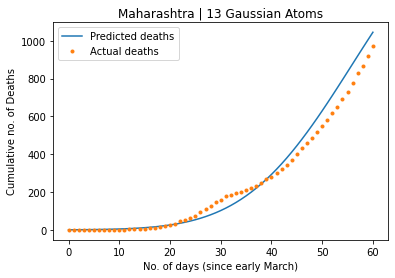

In [182]:
params = model_mh.get_params()
multi_gauss = MultiGaussianCDF(params)
ln_death_rate = np.log(np.cumsum(death_data) + 1)
multi_gauss.fit(ln_death_rate)

preds = multi_gauss.predict(np.arange(ln_death_rate.shape[0]))
plt.plot(np.exp(preds), label="Predicted deaths")
plt.plot(np.cumsum(death_data), '.', label="Actual deaths")
plt.title("Maharashtra | 13 Gaussian Atoms")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative no. of Deaths")
plt.legend()
plt.show()

<h1>Testing predictive power</h1>

Here the model is fit on a subset of the death data. This will then be used extrapolate deaths. The extrapolated deaths can be compared with the actual number of deaths to determine how well the model can predict values. 

<h2>India - single gaussian atom</h2>

In [142]:
fetcher = DataFetcher()
fetcher.fetch()

/Users/ananyeagarwal/Desktop/covid19chal/venv/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


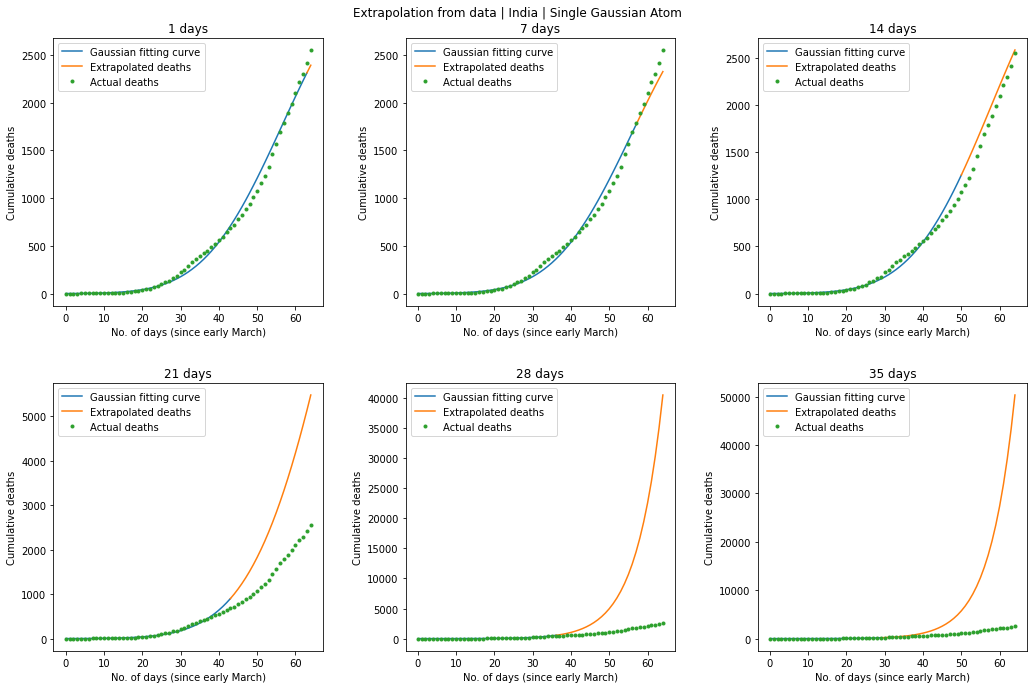

In [154]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
offset = 40

for limit, ax in zip([1, 7, 14, 21, 28, 35], axs.flat):
    death_data = fetcher.cases_time_series['dailydeceased'][offset:]
    time_values = np.arange(death_data.shape[0])

    model_india = GaussianCDF()
    model_india.fit(death_data[:-limit])
    pred = model_india.predict(time_values)

    ax.plot(time_values[:-limit], np.exp(pred)[:-limit], label="Gaussian fitting curve")
    ax.plot(time_values[-limit-1:], np.exp(pred)[-limit-1:], label="Extrapolated deaths")
    ax.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
    ax.set_title("{} days".format(limit))
    ax.set_xlabel("No. of days (since early March)")
    ax.set_ylabel("Cumulative deaths")
    ax.legend()
    
fig.suptitle("Extrapolation from data | India | Single Gaussian Atom")
fig.tight_layout(pad=3.0)
fig.show()

<h2>MH - single gaussian atom</h2>

In [156]:
fetcher = DataFetcherState()
fetcher.fetch()

/Users/ananyeagarwal/Desktop/covid19chal/venv/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


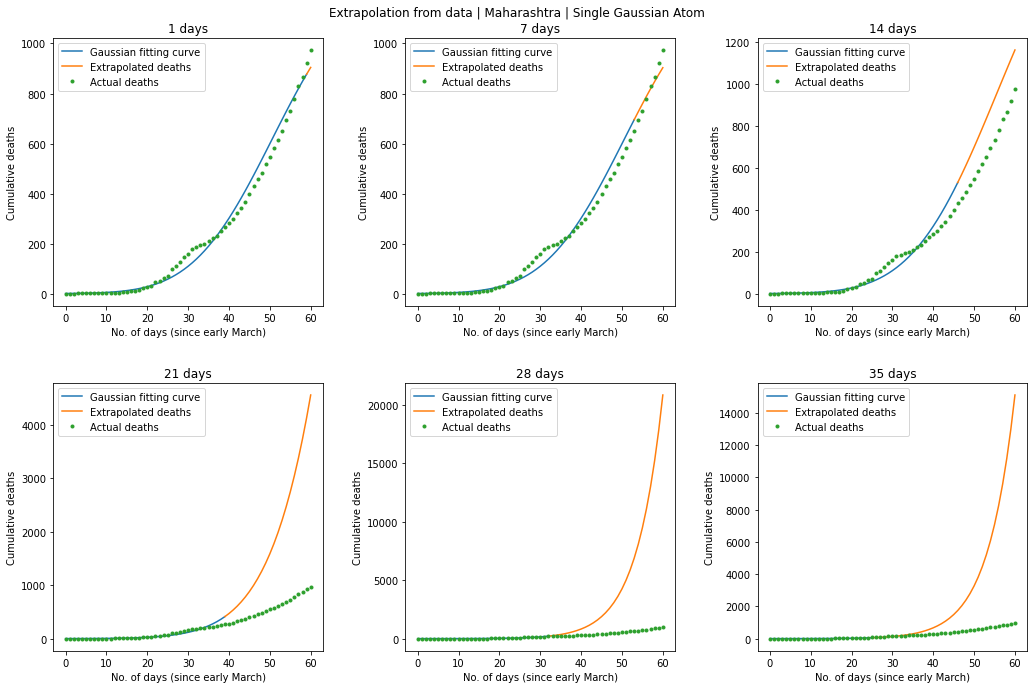

In [163]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for limit, ax in zip([1, 7, 14, 21, 28, 35], axs.flat):
    death_data = np.array(fetcher.data['mh']['deceased'], dtype=float)
    time_values = np.arange(death_data.shape[0], dtype=float)

    model_india = GaussianCDF()
    model_india.fit(death_data[:-limit])
    pred = model_india.predict(time_values)

    ax.plot(time_values[:-limit], np.exp(pred)[:-limit], label="Gaussian fitting curve")
    ax.plot(time_values[-limit-1:], np.exp(pred)[-limit-1:], label="Extrapolated deaths")
    ax.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
    ax.set_title("{} days".format(limit))
    ax.set_xlabel("No. of days (since early March)")
    ax.set_ylabel("Cumulative deaths")
    ax.legend()
    
fig.suptitle("Extrapolation from data | Maharashtra | Single Gaussian Atom")
fig.tight_layout(pad=3.0)
fig.show()

<h1>Peak prediction</h1>

<h2>India - single gaussian atom</h2>

In [174]:
fetcher = DataFetcher()
fetcher.fetch()

In [175]:
offset = 40 # Exclude data from the starting
extra_pred = 60 # How much to predict into the future

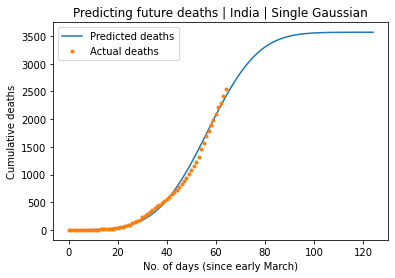

In [176]:
death_data = fetcher.cases_time_series['dailydeceased'][offset:]
time_values = np.arange(death_data.shape[0])

model_india = GaussianCDF()
model_india.fit(death_data)
future_time_values = np.arange(death_data.shape[0] + extra_pred)
pred = model_india.predict(future_time_values)

plt.plot(future_time_values, np.exp(pred), label="Predicted deaths")
plt.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative deaths")
plt.legend()
plt.title("Predicting future deaths | India | Single Gaussian")
plt.show()

<h2>India - multiple gaussian atoms</h2>

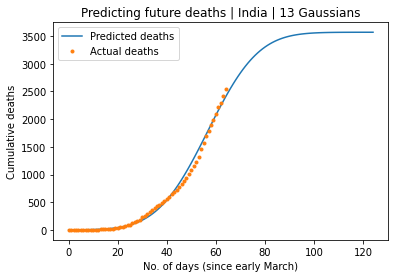

In [177]:
params = model_india.get_params()
multi_gauss = MultiGaussianCDF(params)
ln_death_rate = np.log(np.cumsum(death_data) + 1)
multi_gauss.fit(ln_death_rate)

preds = multi_gauss.predict(future_time_values)

plt.plot(future_time_values, np.exp(pred), label="Predicted deaths")
plt.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative deaths")
plt.legend()
plt.title("Predicting future deaths | India | 13 Gaussians")
plt.show()

<h2>MH - single gaussian atom</h2>

In [178]:
fetcher = DataFetcherState()
fetcher.fetch()

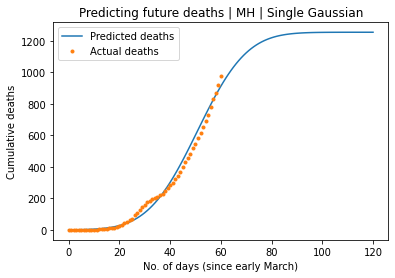

In [179]:
extra_pred = 60
death_data = np.array(fetcher.data['mh']['deceased'], dtype=float)
time_values = np.arange(death_data.shape[0])

model_india = GaussianCDF()
model_india.fit(death_data)
future_time_values = np.arange(death_data.shape[0] + extra_pred)
pred = model_india.predict(future_time_values)

plt.plot(future_time_values, np.exp(pred), label="Predicted deaths")
plt.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative deaths")
plt.legend()
plt.title("Predicting future deaths | MH | Single Gaussian")
plt.show()

<h2>MH - 13 gaussian atoms</h2>

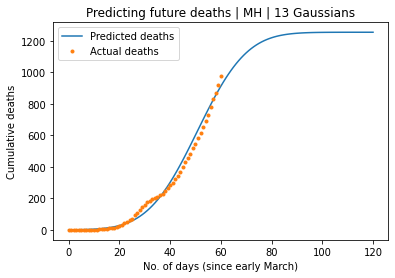

In [180]:
params = model_india.get_params()
multi_gauss = MultiGaussianCDF(params)
ln_death_rate = np.log(np.cumsum(death_data) + 1)
multi_gauss.fit(ln_death_rate)

preds = multi_gauss.predict(future_time_values)

plt.plot(future_time_values, np.exp(pred), label="Predicted deaths")
plt.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative deaths")
plt.legend()
plt.title("Predicting future deaths | MH | 13 Gaussians")
plt.show()